In [30]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")
print("Number of GPUs:", torch.cuda.device_count())


CUDA available: True
GPU name: NVIDIA GeForce RTX 4080
Number of GPUs: 1


In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, TimeDistributed, RepeatVector, Attention, LayerNormalization, Add


In [33]:
df = pd.read_csv("amman_Ready.csv")
df = df.drop(columns=['Unnamed: 0','Liquid Precipitation', 'Cloud Cover %' ])
df.head()

,Air Dew Point,Air Temperature (OC),Humidity %,Atmospheric Pressure,Wind_U,Wind_V
0,-2.0,9.8,43.63,1016.1,-0.0,0.0
1,-2.0,9.0,46.04,1016.1,-0.0,0.0
2,-2.0,9.0,46.04,1016.1,-0.0,0.0
3,-3.1,5.2,55.05,1017.1,-0.0,0.0
4,-3.0,4.0,60.31,1017.1,-0.0,0.0


In [34]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [53]:
data = scaled_data.copy()

In [37]:
n = len(df)
t = 24*3
m = np.arange(0, n-2*t+1)
xi_enc = np.array([data[i:(i+t), :] for i in m])
xi_dec = np.array([data[(i+t-1): (i+2*t-1), :] for i in m])
xo_dec = np.array([data[(i+t):(i+2*t), :] for i in m])

In [38]:
# Assuming xi_enc, xi_dec, xp_dec are NumPy arrays or can be converted to tensors
xi_enc_tensor = torch.tensor(xi_enc, dtype=torch.float32)
xi_dec_tensor = torch.tensor(xi_dec, dtype=torch.float32)
xp_dec_tensor = torch.tensor(xo_dec, dtype=torch.float32)

# Create DataLoader for batching
dataset = TensorDataset(xi_enc_tensor, xi_dec_tensor, xp_dec_tensor)
loader = DataLoader(dataset, batch_size=200, shuffle=False)


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class GRUEncoderDecoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUEncoderDecoder, self).__init__()
        self.hidden_size = hidden_size

        # Encoder GRU
        self.encoder_gru = nn.GRU(input_size, hidden_size, batch_first=True)

        # Decoder GRU
        self.decoder_gru = nn.GRU(input_size, hidden_size, batch_first=True)

        # Output layer
        self.output_layer = nn.Linear(hidden_size, input_size)

    def forward(self, i_enc, i_dec):
        # Encode
        _, h_enc = self.encoder_gru(i_enc)  # h_enc: (num_layers=1, batch_size, hidden_size)

        # Decode
        o_dec, _ = self.decoder_gru(i_dec, h_enc)  # use h_enc as initial state

        # Apply TimeDistributed Dense (output layer applied to each timestep)
        y_dec = self.output_layer(o_dec)  # shape: (batch_size, seq_len, input_size)

        return y_dec

In [40]:

n_feat = xi_enc.shape[2]  # number of features per timestep
n_hidden = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUEncoderDecoder(n_feat, n_hidden).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [41]:
model.train()

history = []
num_epochs = 30

for epoch in range(num_epochs):
    total_loss = 0
    for xi_enc_batch, xi_dec_batch, xp_dec_batch in loader:
        xi_enc_batch = xi_enc_batch.to(device)
        xi_dec_batch = xi_dec_batch.to(device)
        xp_dec_batch = xp_dec_batch.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(xi_enc_batch, xi_dec_batch)

        # Compute loss
        loss = criterion(outputs, xp_dec_batch)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    history.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/30], Loss: 0.0125
Epoch [2/30], Loss: 0.0048
Epoch [3/30], Loss: 0.0064
Epoch [4/30], Loss: 0.0033
Epoch [5/30], Loss: 0.0040
Epoch [6/30], Loss: 0.0031
Epoch [7/30], Loss: 0.0039
Epoch [8/30], Loss: 0.0026
Epoch [9/30], Loss: 0.0030
Epoch [10/30], Loss: 0.0029
Epoch [11/30], Loss: 0.0025
Epoch [12/30], Loss: 0.0026
Epoch [13/30], Loss: 0.0026
Epoch [14/30], Loss: 0.0024
Epoch [15/30], Loss: 0.0024
Epoch [16/30], Loss: 0.0023
Epoch [17/30], Loss: 0.0021
Epoch [18/30], Loss: 0.0024
Epoch [19/30], Loss: 0.0024
Epoch [20/30], Loss: 0.0021
Epoch [21/30], Loss: 0.0024
Epoch [22/30], Loss: 0.0021
Epoch [23/30], Loss: 0.0021
Epoch [24/30], Loss: 0.0023
Epoch [25/30], Loss: 0.0021
Epoch [26/30], Loss: 0.0020
Epoch [27/30], Loss: 0.0022
Epoch [28/30], Loss: 0.0020
Epoch [29/30], Loss: 0.0021
Epoch [30/30], Loss: 0.0020


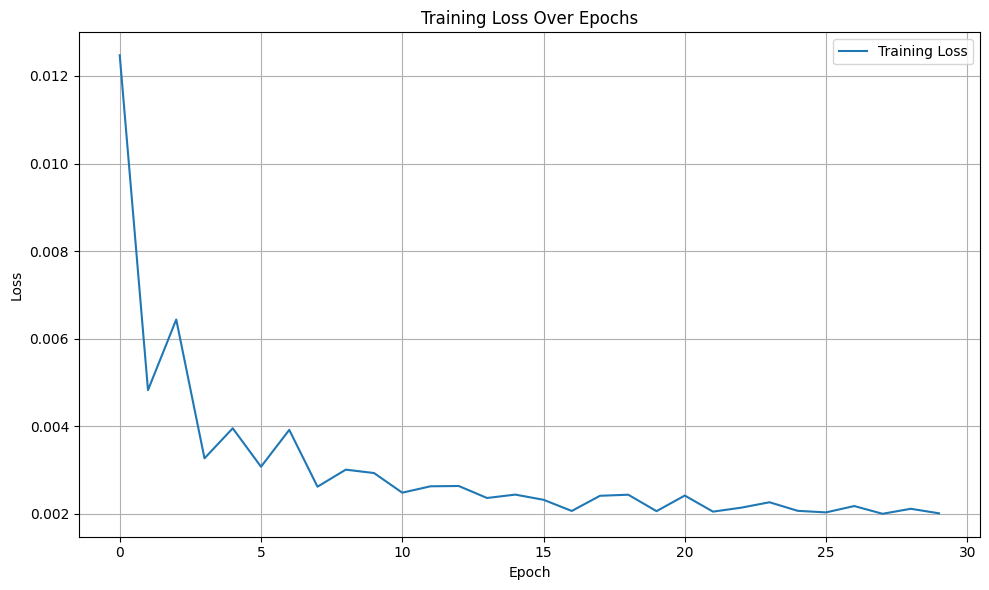

In [42]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        _, h_n = self.gru(x)  # h_n: (num_layers=1, batch_size, hidden_size)
        return h_n


class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Decoder, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, input_size)

    def forward(self, x, hidden):
        # x shape: (batch_size, 1, input_size)
        out, hidden = self.gru(x, hidden)
        out = self.output(out)  # (batch_size, 1, input_size)
        return out, hidden

In [54]:
data.shape

(210384, 6)

In [55]:
print("Shape of data:", data.shape)
print("Shape of data[-n_step:]:", data[-n_step:].shape)
print("Total elements needed:", n_step * n_feat)
print("Available elements:", data[-n_step:].size)

Shape of data: (210384, 6)
Shape of data[-n_step:]: (72, 6)
Total elements needed: 432
Available elements: 432


In [56]:
n_step = xi_enc.shape[1]
n_feat = xi_enc.shape[2] 
n_hidden = 100

encoder = Encoder(n_feat, n_hidden).to(device)
decoder = Decoder(n_feat, n_hidden).to(device)

# Load encoder seed (last 72 points)
e_seed = data[-n_step:].reshape(1, n_step, n_feat)
e_seed_tensor = torch.tensor(e_seed, dtype=torch.float32).to(device)

# Decoder initial input (last point)
d_seed = data[-1].reshape(1, 1, n_feat)
he = encoder(torch.tensor(e_seed, dtype=torch.float32).to(device))


n_future = 24
y_pred = []

with torch.no_grad():
    hidden = he  # initial hidden state from encoder
    input_dec = torch.tensor(d_seed, dtype=torch.float32).to(device)

    for _ in range(n_future):
        output, hidden = decoder(input_dec, hidden)
        y_pred.append(output.cpu().numpy().flatten())
        input_dec = output  # teacher forcing or feedback prediction

y_pred = np.array(y_pred)

In [57]:
y_pred.shape[0]

24

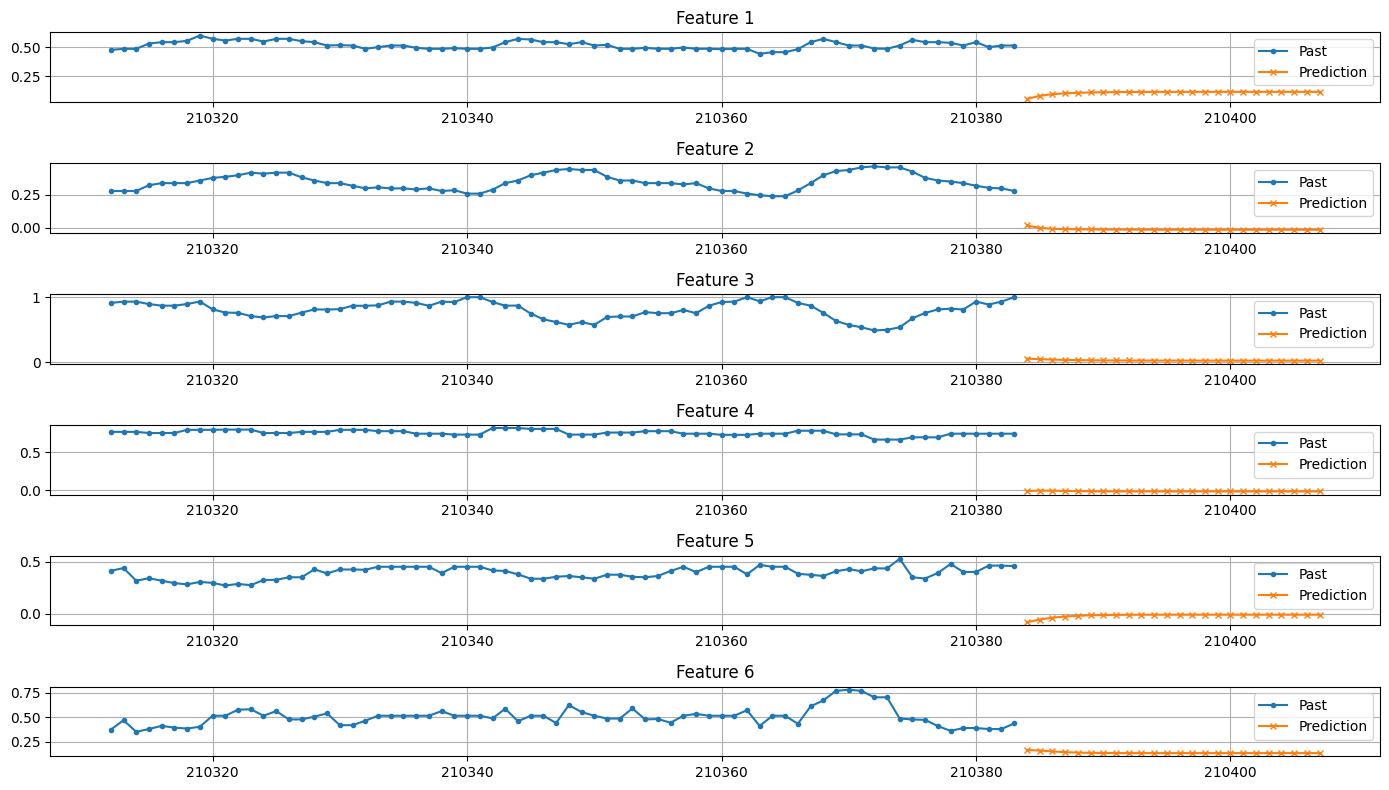

In [58]:
import matplotlib.pyplot as plt

n_future = y_pred.shape[0]

# Time axis for plotting
past_steps = np.arange(data.shape[0] - n_step, data.shape[0])  # last n_step points
future_steps = np.arange(data.shape[0], data.shape[0] + n_future)

# Plotting
plt.figure(figsize=(14, 8))

for i in range(n_feat):
    plt.subplot(n_feat, 1, i+1)
    plt.plot(past_steps, data[-n_step:, i], label='Past', marker='o', markersize=3)
    plt.plot(future_steps, y_pred[:, i], label='Prediction', marker='x', markersize=5)
    plt.title(f'Feature {i+1}')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# smoothed

In [59]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, TimeDistributed, RepeatVector, Attention, LayerNormalization, Add
from keras.models import Model
from keras.layers import Input, Add, LayerNormalization, RepeatVector, TimeDistributed, Dense
from tcn import TCN
import tensorflow as tf

In [73]:
df = pd.read_csv("amman_Ready.csv")
df = df.drop(columns=['Unnamed: 0','Liquid Precipitation', 'Cloud Cover %' ])
df.head()

,Air Dew Point,Air Temperature (OC),Humidity %,Atmospheric Pressure,Wind_U,Wind_V
0,-2.0,9.8,43.63,1016.1,-0.0,0.0
1,-2.0,9.0,46.04,1016.1,-0.0,0.0
2,-2.0,9.0,46.04,1016.1,-0.0,0.0
3,-3.1,5.2,55.05,1017.1,-0.0,0.0
4,-3.0,4.0,60.31,1017.1,-0.0,0.0


In [75]:
def create_sequences(data, input_len, output_len):
    X, y = [], []
    for i in range(len(data) - input_len - output_len):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len])
    return np.array(X), np.array(y)

In [76]:
INPUT_SEQ_LEN = 48
OUTPUT_SEQ_LEN = 24
NUM_FEATURES = scaled_data.shape[1]
BATCH_SIZE = 128

X, y = create_sequences(scaled_data, INPUT_SEQ_LEN, OUTPUT_SEQ_LEN)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [82]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (168249, 48, 6)
y_train shape: (168249, 24, 6)


In [84]:
from keras.models import Model
from keras.layers import Input, Add, LayerNormalization, RepeatVector, TimeDistributed, Dense
from tcn import TCN
import tensorflow as tf

inputs = Input(shape=(INPUT_SEQ_LEN, NUM_FEATURES))

x = TCN(
    nb_filters=64,
    kernel_size=3,
    dilations=[1, 2, 4],  # Explicit dilations
    dropout_rate=0.1,
    use_skip_connections=False,  # Disable unused residuals
    return_sequences=True
)(inputs)

attention = tf.keras.layers.MultiHeadAttention(
    num_heads=2,
    key_dim=32  # Should be nb_filters/num_heads
)(x, x)
x = Add()([x, attention])
x = LayerNormalization()(x)

x = TCN(
    nb_filters=64,
    kernel_size=3,
    dropout_rate=0.1,
    use_skip_connections=False,
    return_sequences=False
)(x)
x = RepeatVector(OUTPUT_SEQ_LEN)(x)

x = TCN(
    nb_filters=64,
    kernel_size=3,
    dropout_rate=0.1,
    use_skip_connections=False,
    return_sequences=True
)(x)
outputs = TimeDistributed(Dense(NUM_FEATURES))(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',  # Using MSE for stability
    metrics=['mae']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 48, 6)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tcn_9 (TCN)                   │ (None, 48, 64)            │          63,424 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_3        │ (None, 48, 64)            │          16,640 │ tcn_9[0][0], tcn_9[0][0]   │
│ (MultiHeadAttention)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_3 (Add)                   │ (None, 48, 64)            │               0 │ tcn_9[0][0],               │
│                               │                           │                 │ multi_head_attention_3[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_3         │ (None, 48, 64)            │             128 │ add_3[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tcn_10 (TCN)                  │ (None, 64)                │         148,224 │ layer_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ repeat_vector_3               │ (None, 24, 64)            │               0 │ tcn_10[0][0]               │
│ (RepeatVector)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tcn_11 (TCN)                  │ (None, 24, 64)            │         148,224 │ repeat_vector_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_3            │ (None, 24, 6)             │             390 │ tcn_11[0][0]               │
│ (TimeDistributed)             │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 377,030 (1.44 MB)

 Trainable params: 377,030 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=128
)


Epoch 1/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 88s 63ms/step - loss: 206.1483 - mae: 2.2682 - val_loss: 0.0279 - val_mae: 0.1259
Epoch 2/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 92s 70ms/step - loss: 0.0794 - mae: 0.2171 - val_loss: 0.0236 - val_mae: 0.1157
Epoch 3/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 83s 63ms/step - loss: 0.0500 - mae: 0.1729 - val_loss: 0.0197 - val_mae: 0.1060
Epoch 4/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 93s 71ms/step - loss: 0.0362 - mae: 0.1468 - val_loss: 0.0171 - val_mae: 0.1002
Epoch 5/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 85s 64ms/step - loss: 0.0288 - mae: 0.1308 - val_loss: 0.0146 - val_mae: 0.0929
Epoch 6/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 95s 72ms/step - loss: 0.0231 - mae: 0.1168 - val_loss: 0.0128 - val_mae: 0.0866
Epoch 7/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 88s 67ms/step - loss: 0.0193 - mae: 0.1066 - val_loss: 0.0115 - val_mae: 0.0820
Epoch 8/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 93s 71ms/step - loss: 0.0167 - mae: 0.0987 - val_loss: 0.0104 - val_mae: 0.0772
Epoch 9/20
1315/1315 ━

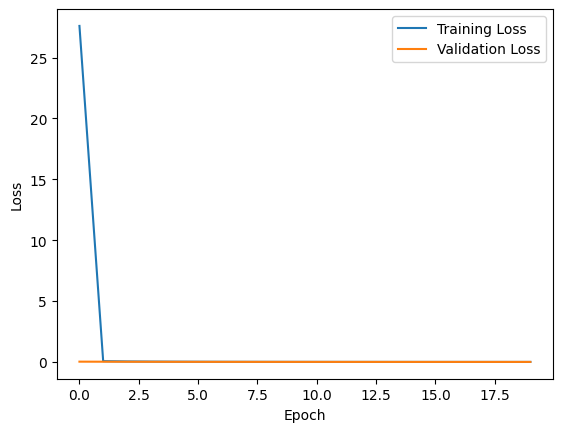

In [86]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [87]:
loss, mae = model.evaluate(X_test, y_test) # added mse to the unpacking of the results
print(f"Test Loss: {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

658/658 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0059 - mae: 0.0551
Test Loss: 0.0059
Test MAE: 0.0548


658/658 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step


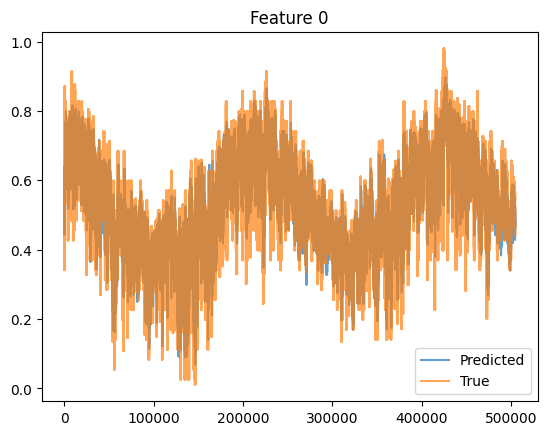

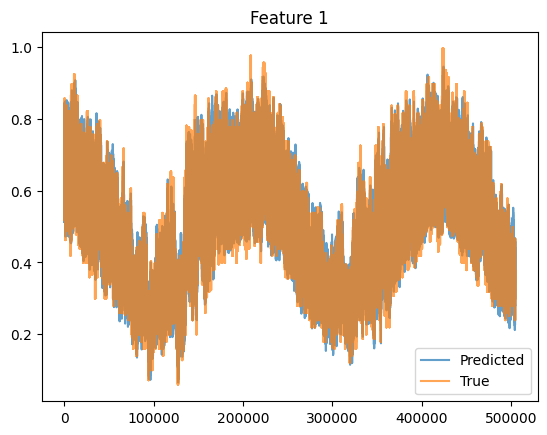

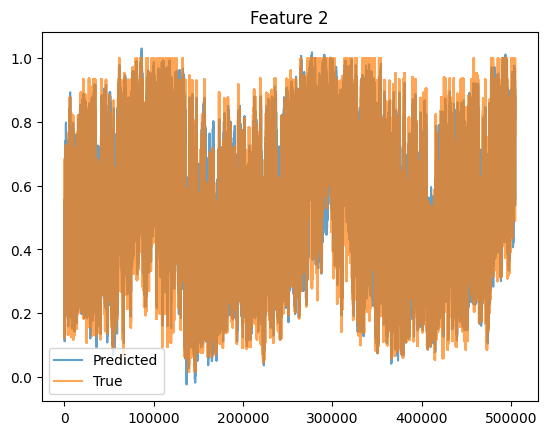

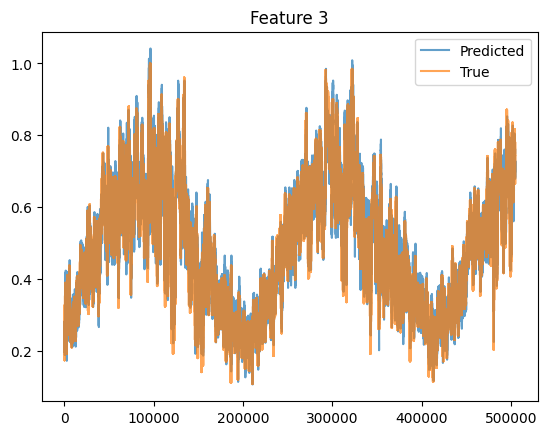

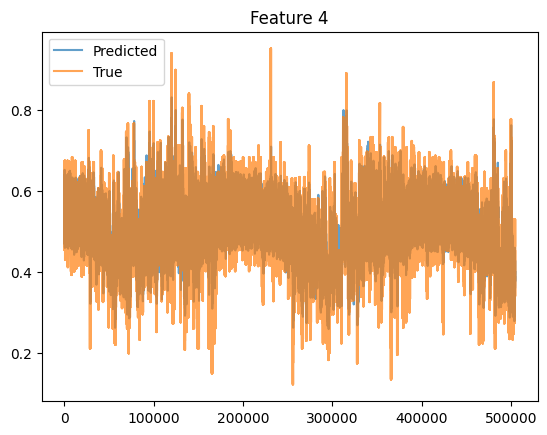

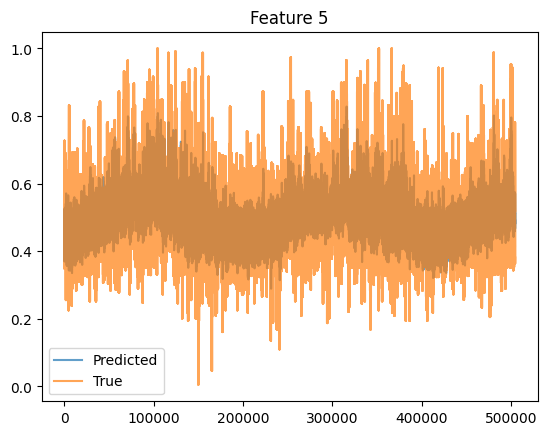

In [88]:
pred = model.predict(X_test)
true = y_test

num_samples = pred.shape[0]
pred_2d = pred.reshape(num_samples * OUTPUT_SEQ_LEN, NUM_FEATURES)
true_2d = true.reshape(num_samples * OUTPUT_SEQ_LEN, NUM_FEATURES)

for j in range(NUM_FEATURES):
    plt.figure()
    plt.plot(pred_2d[:, j], label="Predicted", alpha=0.7)
    plt.plot(true_2d[:, j], label="True", alpha=0.7)
    plt.title(f"Feature {j}")
    plt.legend()
    plt.show()

In [91]:
test = pd.read_csv('amman_test.csv')
test = test.drop(columns=['Unnamed: 0','Liquid Precipitation', 'Cloud Cover %' ])
scaled_test = scaler.transform(df)

In [97]:
_,y = create_sequences(scaled_test, INPUT_SEQ_LEN, OUTPUT_SEQ_LEN)

6573/6573 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step


C:\Users\20210614\.conda\envs\tf_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


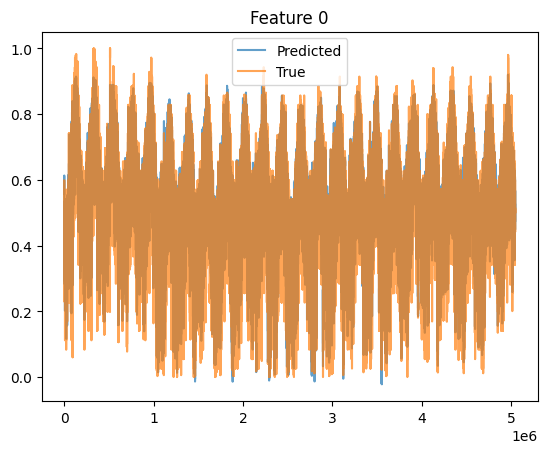

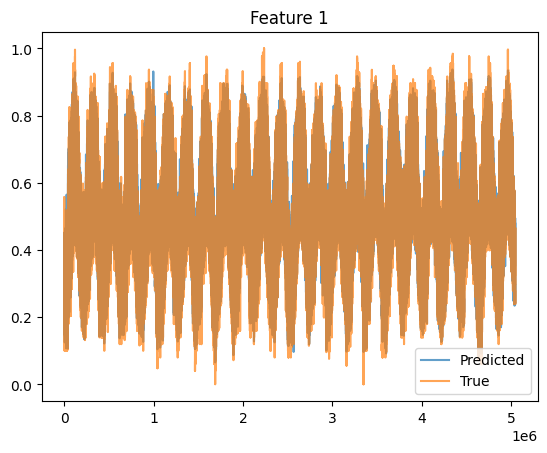

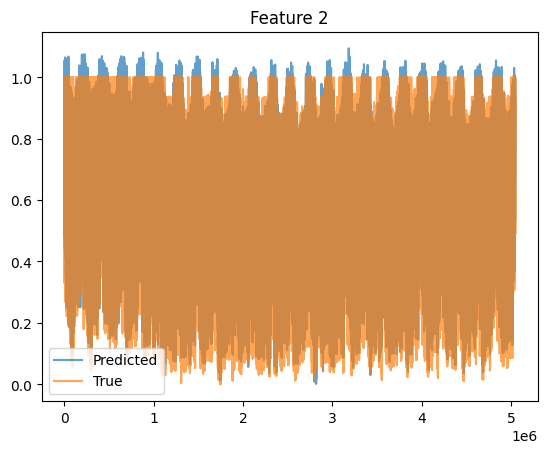

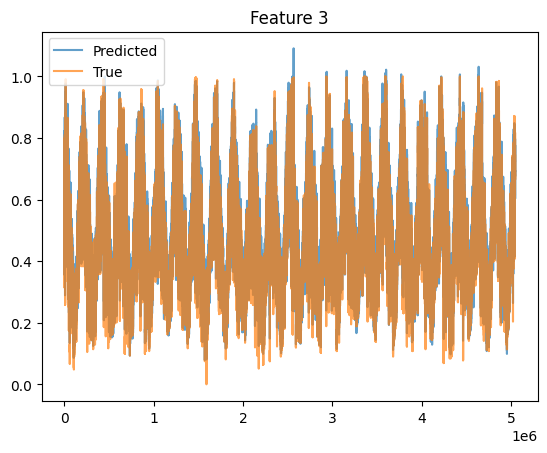

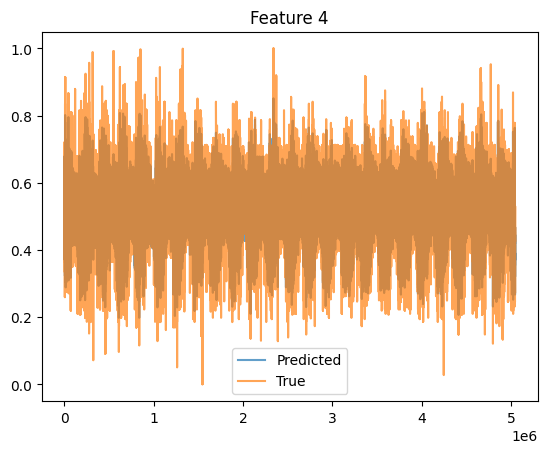

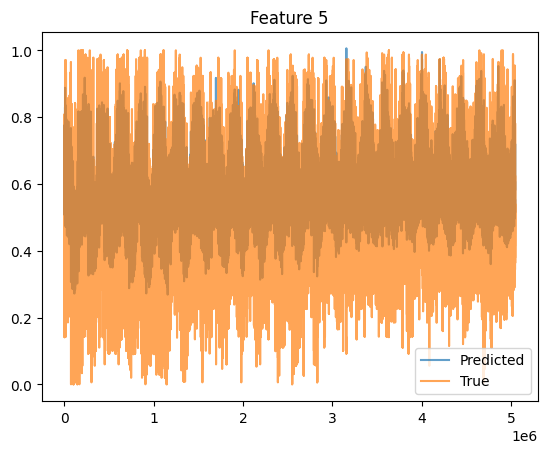

In [98]:
pred = model.predict(y)
true = y

num_samples = pred.shape[0]
pred_2d = pred.reshape(num_samples * OUTPUT_SEQ_LEN, NUM_FEATURES)
true_2d = true.reshape(num_samples * OUTPUT_SEQ_LEN, NUM_FEATURES)

for j in range(NUM_FEATURES):
    plt.figure()
    plt.plot(pred_2d[:, j], label="Predicted", alpha=0.7)
    plt.plot(true_2d[:, j], label="True", alpha=0.7)
    plt.title(f"Feature {j}")
    plt.legend()
    plt.show()

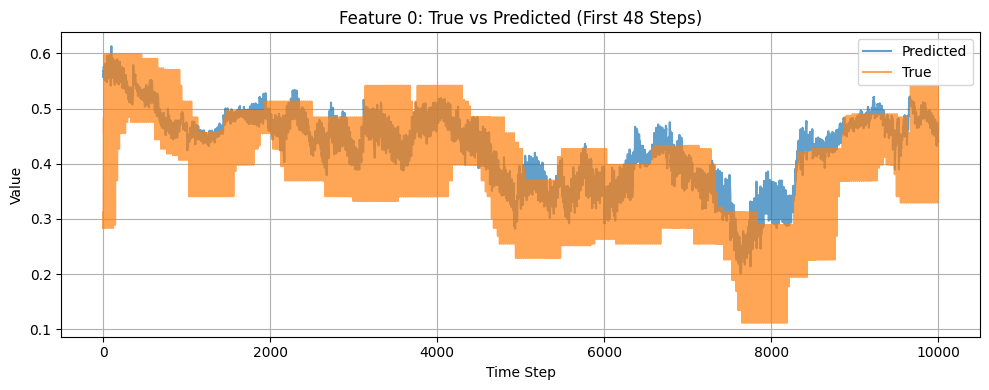

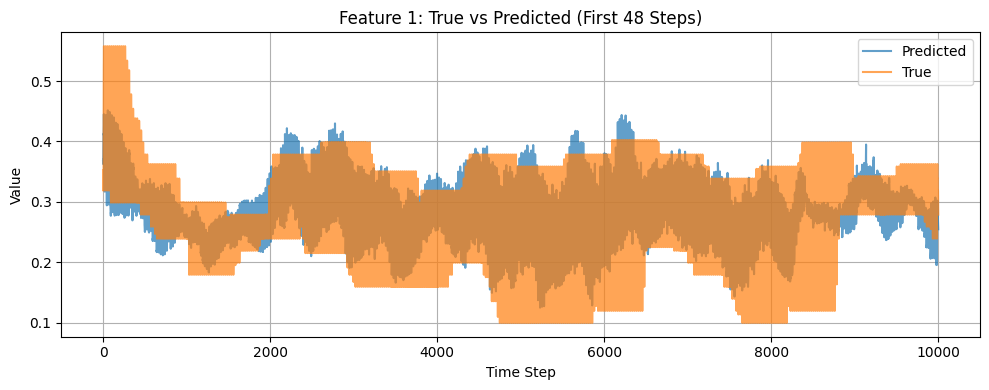

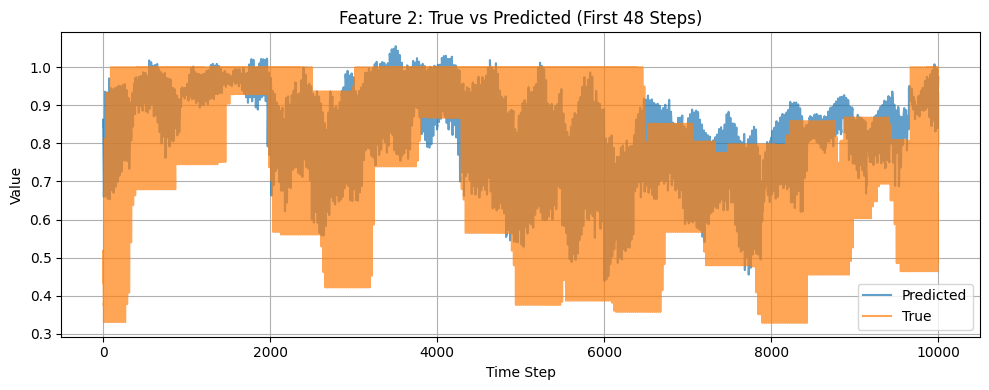

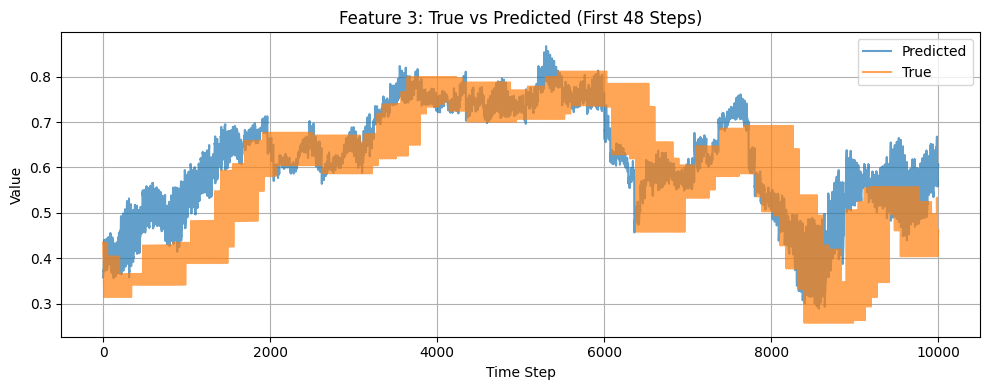

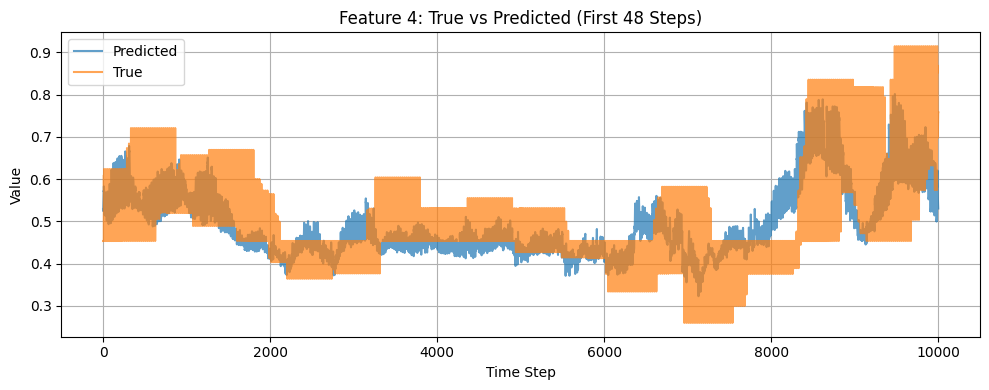

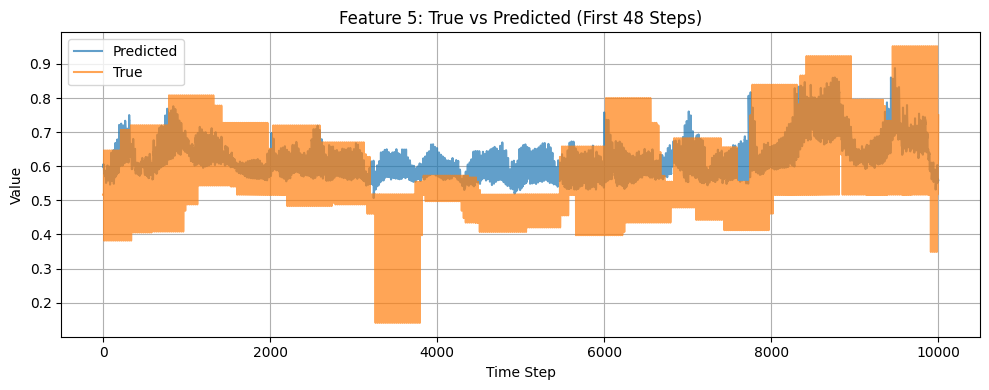

In [102]:
for j in range(NUM_FEATURES):
    plt.figure(figsize=(10, 4))
    plt.plot(pred_2d[:10000, j], label="Predicted", alpha=0.7)
    plt.plot(true_2d[:10000, j], label="True", alpha=0.7)
    plt.title(f"Feature {j}: True vs Predicted (First 48 Steps)")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

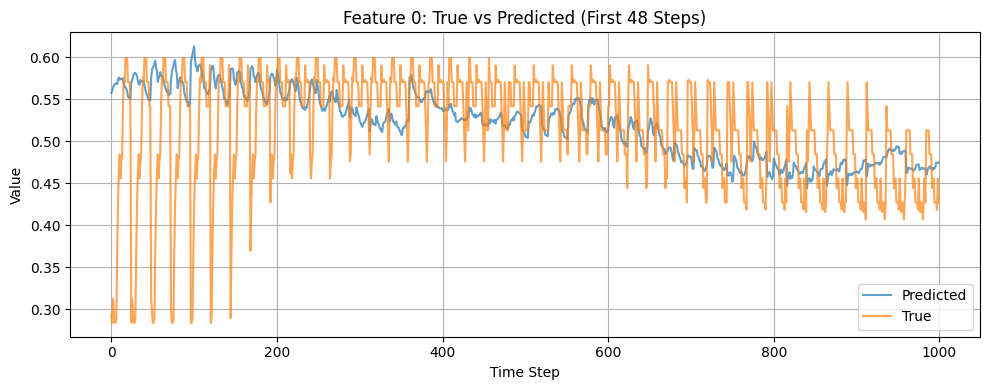

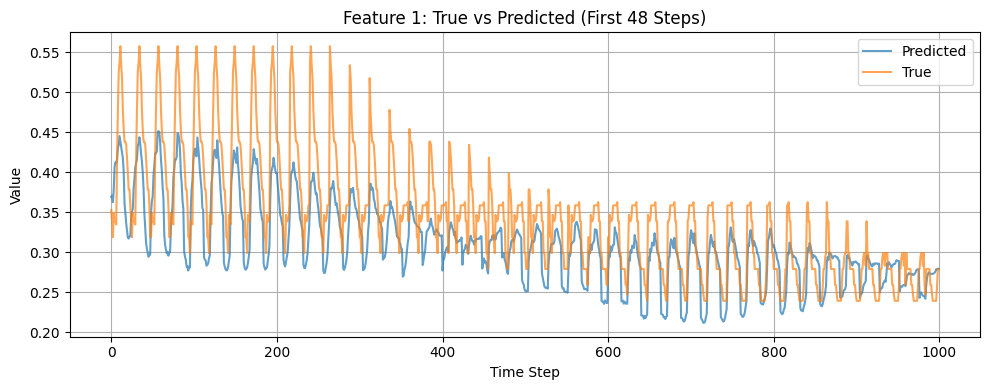

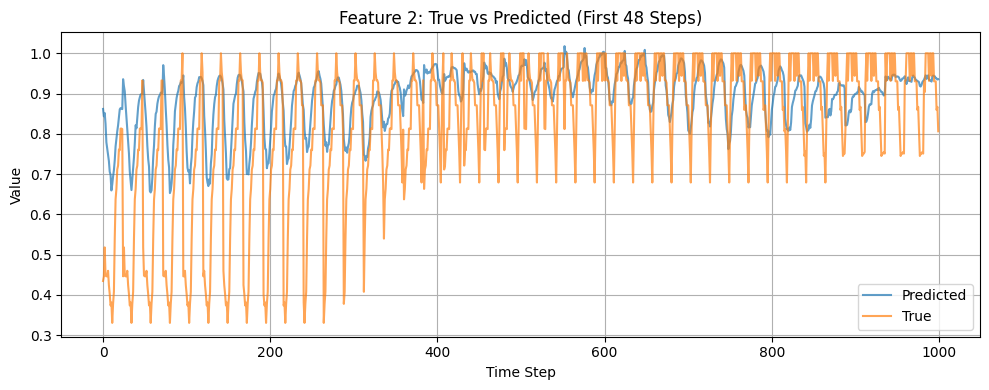

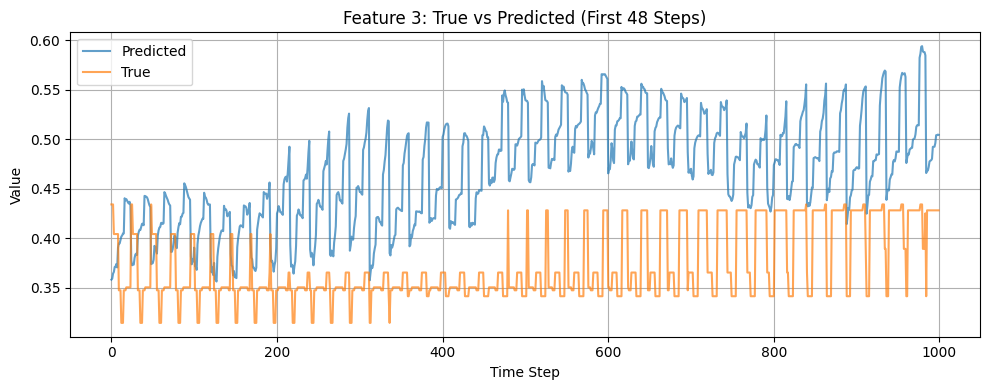

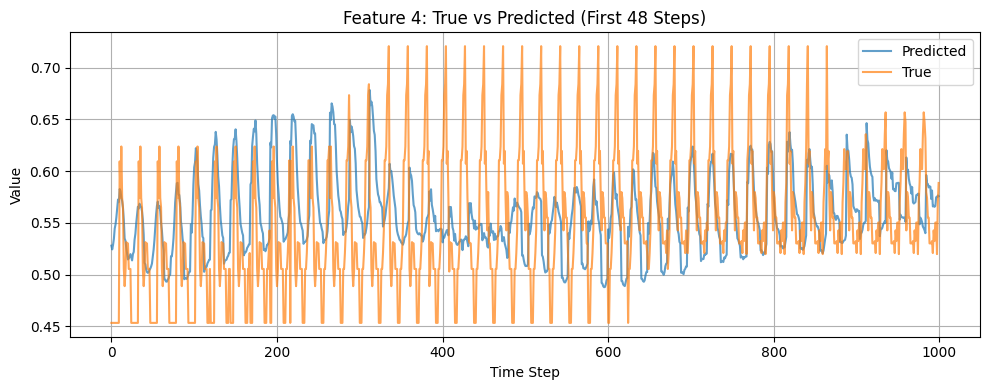

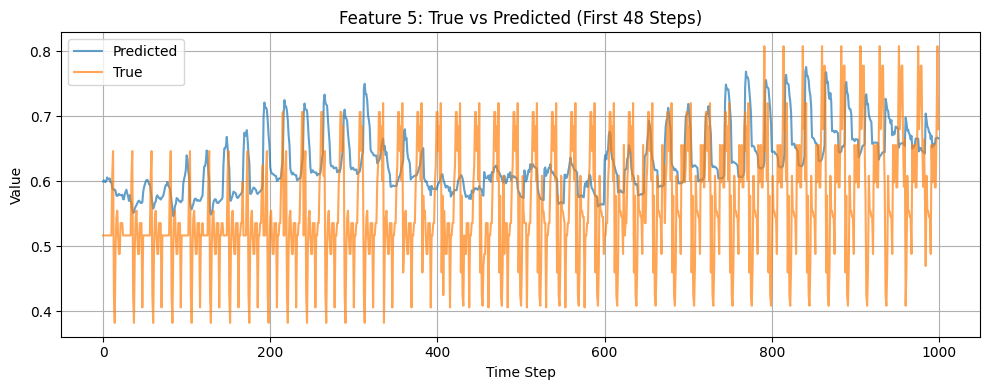

In [103]:
for j in range(NUM_FEATURES):
    plt.figure(figsize=(10, 4))
    plt.plot(pred_2d[:1000, j], label="Predicted", alpha=0.7)
    plt.plot(true_2d[:1000, j], label="True", alpha=0.7)
    plt.title(f"Feature {j}: True vs Predicted (First 48 Steps)")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

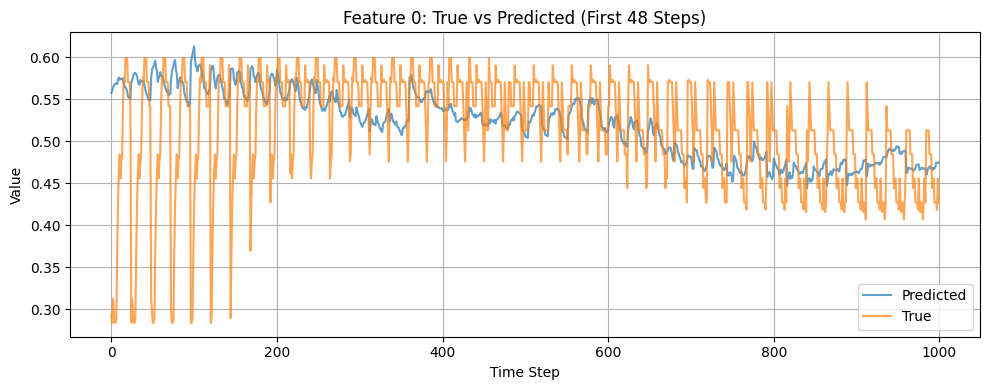

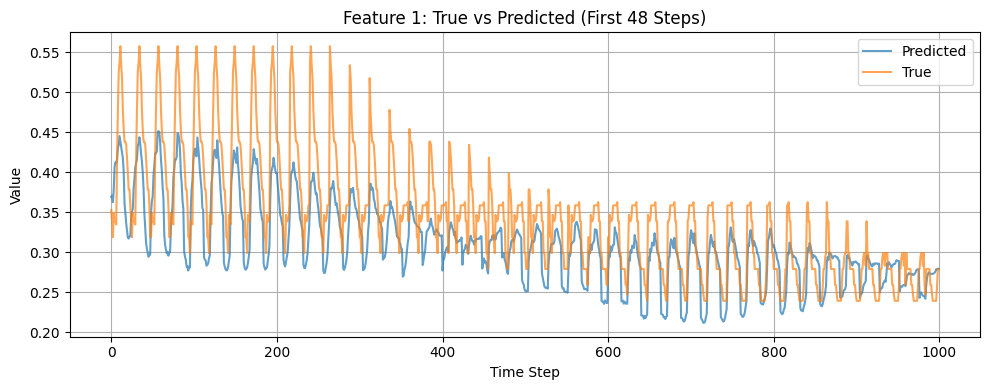

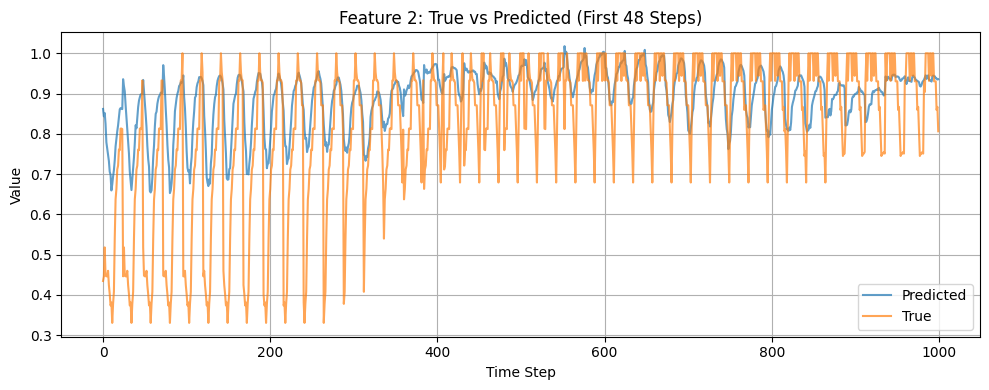

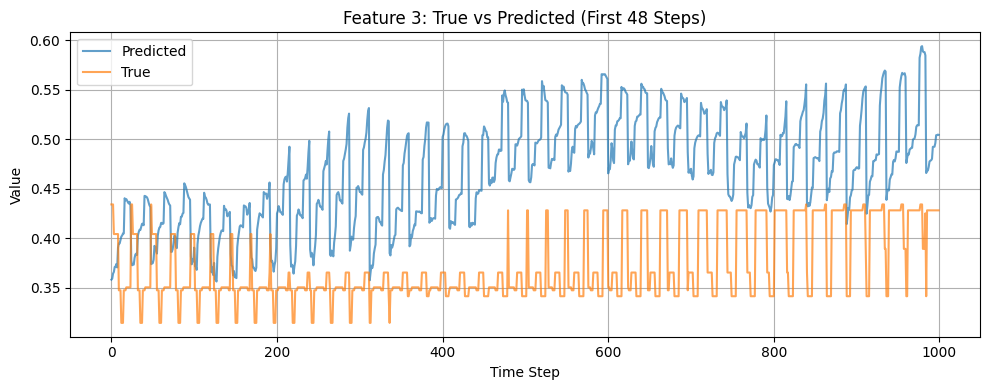

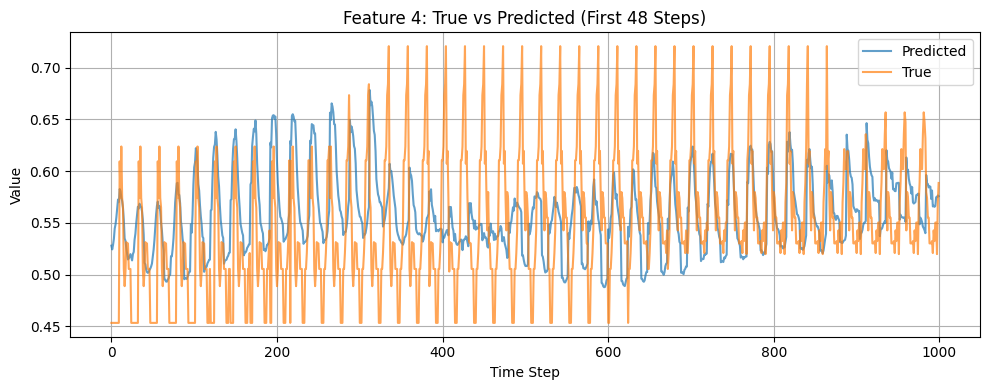

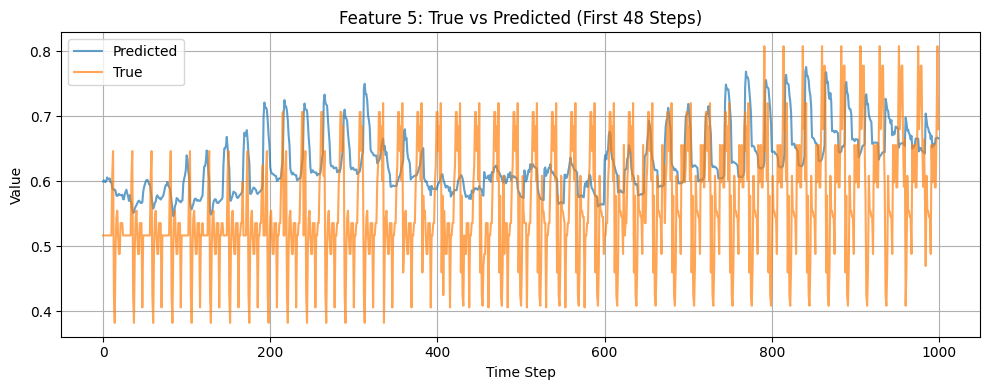

In [104]:
for j in range(NUM_FEATURES):
    plt.figure(figsize=(10, 4))
    plt.plot(pred_2d[:1000, j], label="Predicted", alpha=0.7)
    plt.plot(true_2d[:1000, j], label="True", alpha=0.7)
    plt.title(f"Feature {j}: True vs Predicted (First 48 Steps)")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

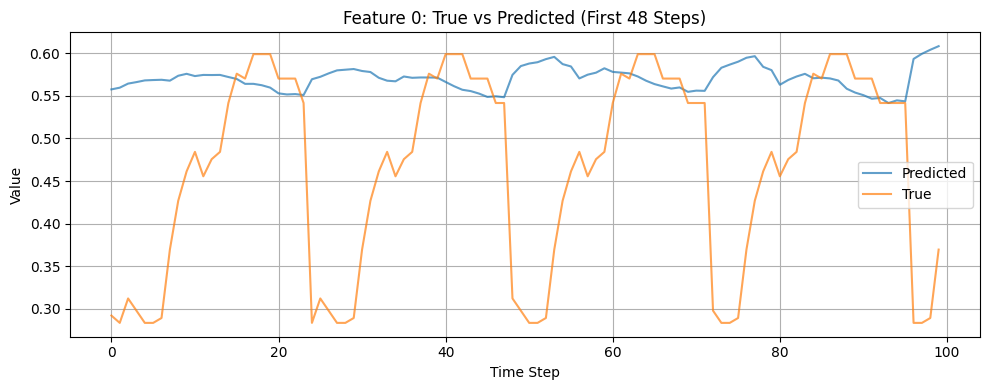

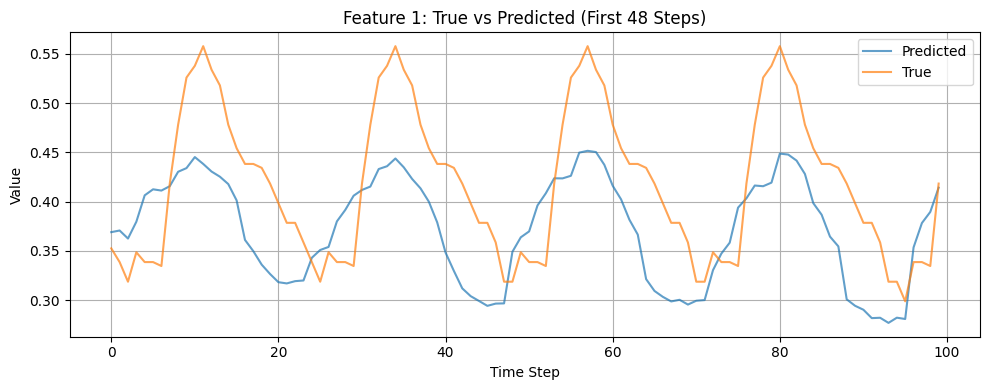

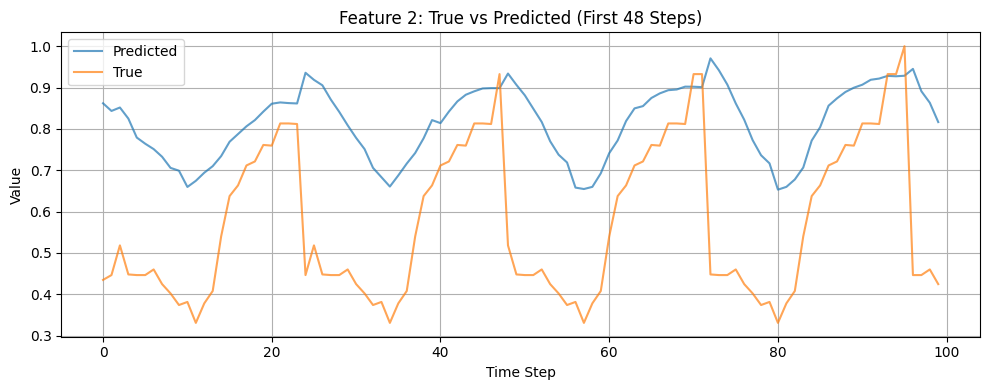

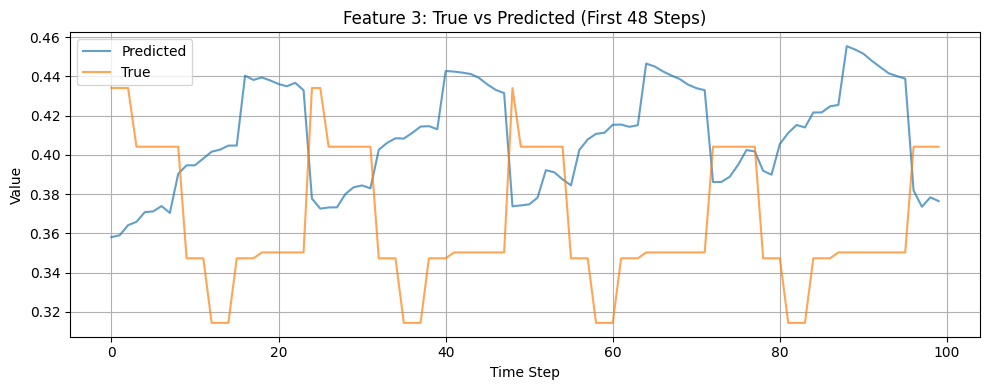

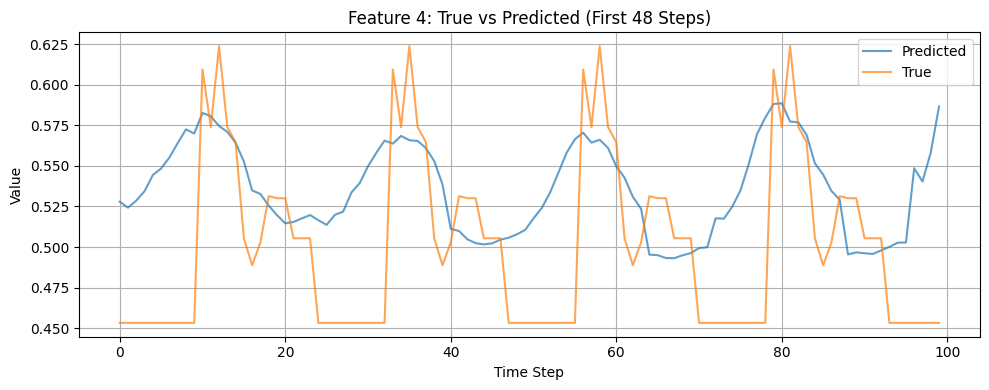

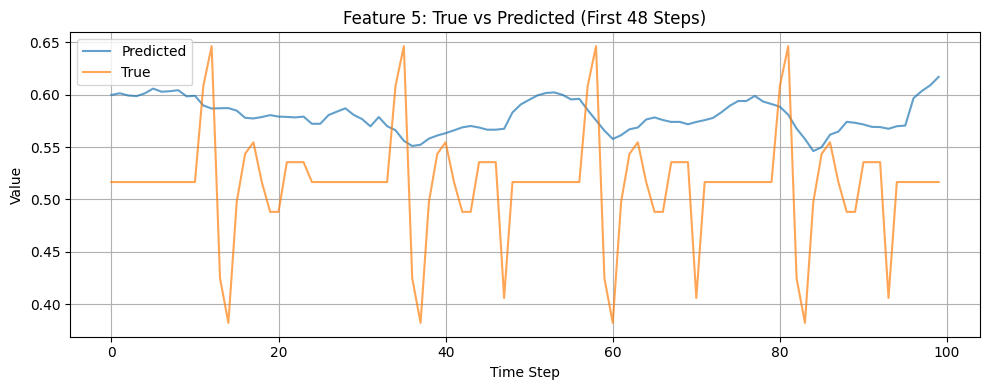

In [105]:
for j in range(NUM_FEATURES):
    plt.figure(figsize=(10, 4))
    plt.plot(pred_2d[:100, j], label="Predicted", alpha=0.7)
    plt.plot(true_2d[:100, j], label="True", alpha=0.7)
    plt.title(f"Feature {j}: True vs Predicted (First 48 Steps)")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()